In [88]:
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
import string
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import style
style.use('default')

## 3 (50 puntos) Probabilidades: Algoritmo de Maximización de la Esperanza

A continuación, implemente el algoritmo de maximización de la esperanza (descrito en el material del curso), usando la definición y descripción de las siguientes funciones como base:

1. (5 puntos) Implemente la función generate_data la cual reciba la cantidad de observaciones unidimensionales total a generar N, y los parámetros correspondientes a K=2 funciones de densidad Gaussianas. Genere los datos siguiendo tales distribuciones, y retorne tal matriz de datos $X\in\mathbb{R}^{N}$.

    a) Grafique los datos usando un scatter plot junto con las gráficas de la función de densidad de probabilidad, en la misma figura (gráfico).



In [89]:
%matplotlib widget
from cProfile import label
import random

def generate_data(N,K=2):
    
    results=torch.tensor(())
    real_parameters=torch.tensor(())
    for k in range(K):
        
        μ = round(random.uniform(-100, 100), 1)
        σ = round(random.uniform(0.1, 100), 1)

        normal_dist_n = torch.distributions.normal.Normal(torch.tensor([μ]), torch.tensor([σ]))
        gaussian_sample = normal_dist_n.sample((int(N/2),1)).squeeze()
        #plt.plot(gaussian_sample, norm.pdf(gaussian_sample,μ,σ),label="Func "+ str(k) +": μ=" + str(μ) + " σ=" + str(σ))
        real_parameters=torch.cat((real_parameters,torch.tensor((μ,σ))),0)
        results=torch.cat((results,gaussian_sample),0)

    print("The initial parameters are: ", torch.reshape(real_parameters,(2,2)))
    return results

2. (5 puntos) Implemente la función init_random_parameters la cual genere una matriz de $P\in\mathbb{R}^{K\times2}$ dimensiones, con los parámetros de las funciones de densidad Gaussiana generados completamente al azar. 

    a) Muestre un pantallazo donde verifique su funcionamiento correcto con los comentarios asociados.

In [90]:
import random

def init_random_parameters(K=2):

    random_parameters=torch.tensor(())
    for k in range(K):
        
        μ = round(random.uniform(-100, 100), 1)
        σ = round(random.uniform(0.1, 100), 1)      

        random_parameters=torch.cat((random_parameters,torch.tensor((μ,σ))),0)
    
    return torch.reshape(random_parameters,(2,2))

3. (5 puntos) Implemente la función calculate_likelihood_gaussian_observation($x_n$, $mu_k$, $sigma_k$) la cual calcule la verosimilitud de una observación específica $x_{n}$, para una función de densidad Gaussiana con parámetros $\mu_{k}$ y $\sigma_{k}$. 

    a) Muestre un pantallazo donde verifique su funcionamiento correcto con los comentarios asociados.



In [91]:
def  calculate_likelihood_gaussian_observation(x_ni,mu_ki,sigma_k):
    #Segun clase
    #return (1/(torch.sqrt(torch.tensor(2.0) * torch.pi*sigma_k**2))) * torch.e**((-1/2)*((x_ni-mu_ki)/sigma_k)**2)
    #Segun doc repaso
    return (1/(torch.sqrt(torch.tensor(2.0) * torch.pi*(sigma_k**2)))) * torch.e**((-1/2)*(((x_ni-mu_ki)/sigma_k)**2))
    #return (1/(torch.sqrt(torch.tensor(2.0) * torch.pi*(sigma_k**2)))) * torch.e**((-1/2)*(((x_ni-mu_ki)/ torch.tensor(2.0) * sigma_k)**2))  

4. (5 puntos) Implemente la función calculate_membership_dataset(X_dataset, Parameters_matrix), la cual, usando la matriz de parámetros P y la función anteriormente implementada calculate_likelihood_gaussian_observation, defina por cada observación $x_{n}\in X$ la pertenencia o membresía a cada cluster $k=1,\ldots K$, en una matriz binaria $M\in\mathbb{R}^{N\times K}$. Retorne tal matriz de membresía M. 

    a) Muestre un pantallazo donde verifique su funcionamiento correcto con los comentarios asociados.



In [92]:
def calculate_membership_dataset(X_dataset, parameters_matrix):
  
    membership_matrix=torch.empty(len(X_dataset),2)
      
    
    for i in range(len(X_dataset)):
        #print(calculate_likelihood_gaussian_observation(X_dataset[i],parameter_matrix[0][0],parameter_matrix[0][1]))
        #print(calculate_likelihood_gaussian_observation(X_dataset[i],parameter_matrix[1][0],parameter_matrix[1][1]))

        if (calculate_likelihood_gaussian_observation(X_dataset[i],parameters_matrix[0][0],parameters_matrix[0][1])) >= calculate_likelihood_gaussian_observation(X_dataset[i],parameters_matrix[1][0],parameters_matrix[1][1]):
            membership_matrix[i][0]=1
            membership_matrix[i][1]=0
        else:
            membership_matrix[i][0]=0
            membership_matrix[i][1]=1
    
    return membership_matrix

5. (5 puntos) Implemente la función recalculate_parameters(X_dataset, Membership_data), la cual recalcule los parámetros de las funciones de densidad Gaussianas representandas en la matriz P, de acuerdo a lo representado en la matriz de membresía M.

    a) Use las funciones mean y std de pytorch para ello. Intente prescindir al máximo de estructuras de repetición tipo for. 



In [93]:
def recalculate_parameters(X_dataset,membership_data):
    recalculated_parameters=torch.empty(2,2)
    #Cantidad de 1s de la funcion k en la matrix de membresia.
    N_i_k0=0
    N_i_k1=0
   
    #Se cuentan los 1 para cada k y se anota el indice en una variable temporal
    values_k0=torch.tensor(())
    values_k1=torch.tensor(())

    for i in range(len(membership_data)):
        if membership_data[i][0]==1:
            N_i_k0+=1
            values_k0=torch.cat((values_k0,torch.tensor((X_dataset[i],))))
        else:
            N_i_k1+=1
            values_k1=torch.cat((values_k1,torch.tensor((X_dataset[i],))))

    #Armar la nueva matriz con los valores recalculados:
    recalculated_parameters[0][0]=values_k0.mean().nan_to_num(nan=torch.finfo(torch.float32).eps)
    recalculated_parameters[0][1]=values_k0.std().nan_to_num(nan=torch.finfo(torch.float32).eps)
    recalculated_parameters[1][0]=values_k1.mean().nan_to_num(nan=torch.finfo(torch.float32).eps)
    recalculated_parameters[1][1]=values_k1.std().nan_to_num(nan=torch.finfo(torch.float32).eps)

    print("La nueva matriz de parametros es: ",recalculated_parameters)

    #print("Las N_i para K0 son", N_i_k0)
    #print("La muestra para k0 son ",values_k0)
    #print("Las N_i para K1 son", N_i_k1)
    #print("Los muestra para k1 son ",values_k1)

    return recalculated_parameters

6. (15 puntos) Ejecute 5 corridas diferentes del algoritmo, donde por cada una documente los parámetros a los que se arribó. 

    a) Grafique las funciones de densidad de probabilidad a las que convergió el algoritmo. Puede graficar también las funciones de densidad obtenidas en 2 o 3 pasos intermedios. 

    b) Comente los resultados.



The initial parameters are:  tensor([[ 72.7000,  34.0000],
        [-79.8000,  20.9000]])


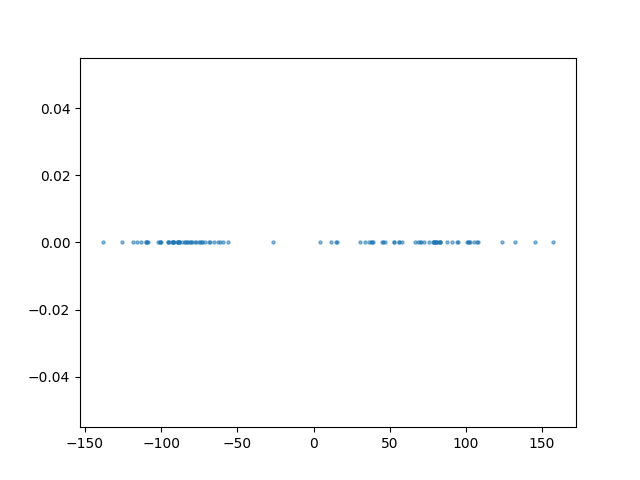

In [122]:
dataset=generate_data(100)
parameter_matrix=init_random_parameters()
plt.figure()
plt.scatter(dataset,torch.zeros(len(dataset)),s=5, alpha=0.5,label="Random data")
plt.show()

Iteación  0


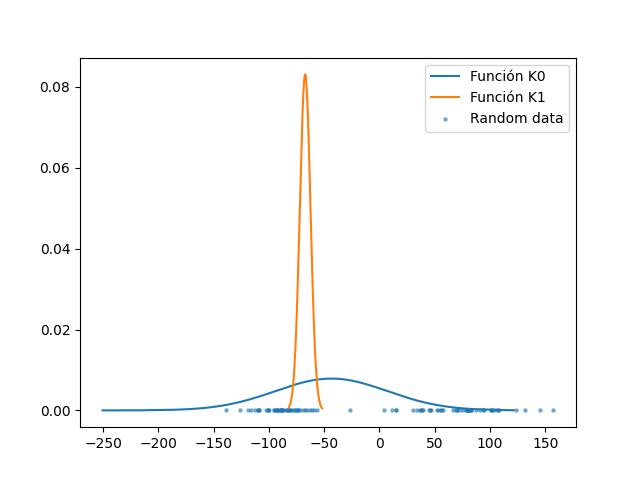

La nueva matriz de parametros es:  tensor([[  1.8754,  87.5189],
        [-69.8384,   6.1327]])
Iteación  1


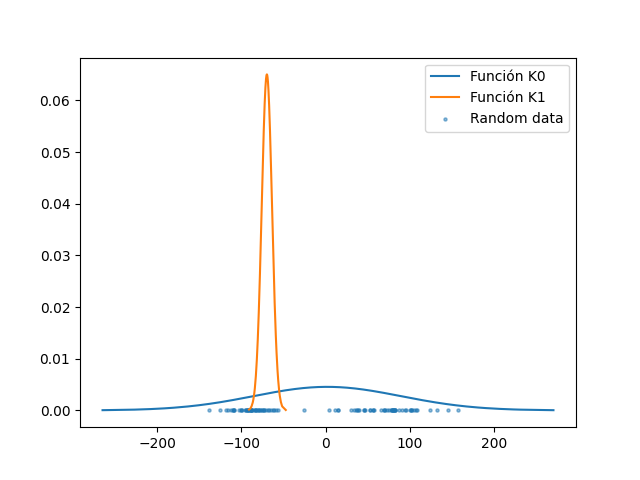

La nueva matriz de parametros es:  tensor([[ 10.0571,  87.7506],
        [-73.2975,   8.5400]])
Iteación  2


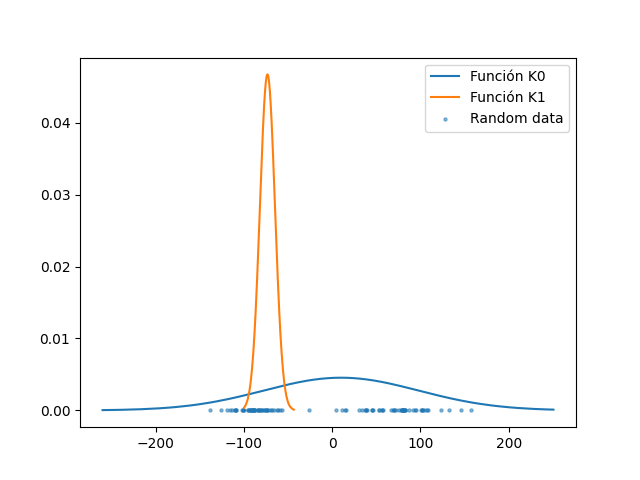

La nueva matriz de parametros es:  tensor([[ 27.9668,  83.4013],
        [-79.3488,  10.6435]])
Iteación  3


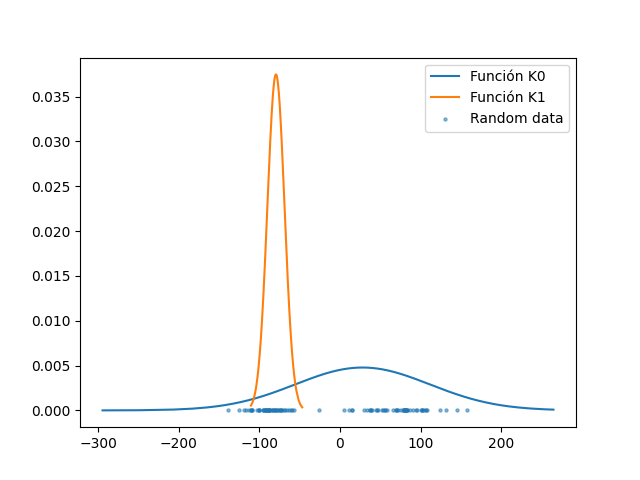

La nueva matriz de parametros es:  tensor([[ 42.7193,  75.2432],
        [-82.6974,  12.1984]])
Iteación  4


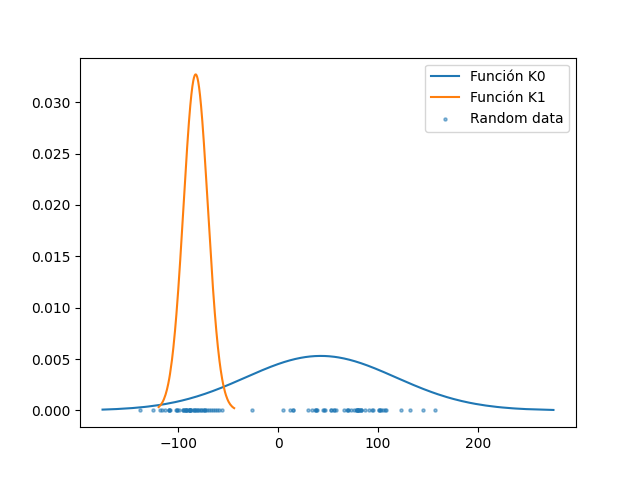

La nueva matriz de parametros es:  tensor([[ 59.8145,  57.6548],
        [-86.4070,  14.9559]])


In [123]:
for i in range(5):
    
    normal_dist_1 = torch.distributions.normal.Normal(parameter_matrix[0][0],parameter_matrix[0][1])
    gaussian_sample_1, indexes = normal_dist_1.sample((1000,1)).squeeze().sort()

    normal_dist_2 = torch.distributions.normal.Normal(parameter_matrix[1][0],parameter_matrix[1][1])
    gaussian_sample_2, indexes = normal_dist_2.sample((1000,1)).squeeze().sort()
    
    print("Iteación ", i)
    plt.figure()
    plt.plot(gaussian_sample_1, norm.pdf(gaussian_sample_1,parameter_matrix[0][0],parameter_matrix[0][1]),label="Función K0")
    plt.plot(gaussian_sample_2, norm.pdf(gaussian_sample_2,parameter_matrix[1][0],parameter_matrix[1][1]),label="Función K1")
    plt.scatter(dataset,torch.zeros(len(dataset)),s=5, alpha=0.5,label="Random data")
    plt.legend()
    plt.show()

    membership_data=calculate_membership_dataset(dataset,parameter_matrix)

    parameter_matrix=recalculate_parameters(dataset,membership_data)

7. (10 puntos) Proponga una mejor heurística para inicializar los parámetros del modelo aleatoriamente. 

    a) Compruebe la mejora obtenida con el método propuesto, corriendo las pruebas del punto anterior.